In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *
from collections import defaultdict

In [2]:
data_dir = '/datadrive/data_cs/'
batch_size = 128
batch_num  = 128
epoch_num  = 200

device = torch.device("cuda:1")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
# len(graph.node_feature['paper']['time'])
# tot = 0
# for t in train_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# tot = 0
# for t in valid_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# tot = 0
# for t in test_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# l = [377082, 77467, 89695]
# l = np.array(l)
# l / np.sum(l)

In [5]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs
    
class CPC_Predictor(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(CPC_Predictor, self).__init__()
        self.gnn = GNN(in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout)
        self.matcher = nn.Linear(n_hid, n_heads)
        self.score   = nn.Linear(n_heads, 1)
        
    def forward(self, pos_paper_ids, neg_paper_ids, node_feature, node_type, edge_time, edge_index, edge_type):
        meta_xs = self.gnn(node_feature, node_type, edge_time, edge_index, edge_type)
        meta_xs = self.score(F.elu(self.matcher(meta_xs)))
        pos_res = meta_xs[pos_paper_ids]
        neg_res = meta_xs[neg_paper_ids]
        neg_res = neg_res.view(pos_res.size(0), neg_res.size(0) // pos_res.size(0))
        return torch.cat([pos_res, neg_res], dim=-1)

def gen_negative_sample(dim1, dim2, num):
    res = []
    for i in range(num):
        res += [[np.random.randint(dim1), np.random.randint(dim2)]]
    return res

def neg_sample(size, pos_id, num):
    res = {}
    while len(res) != num:
        s = np.random.choice(size)
        if s in res or s == pos_id:
            continue
        res[s] = True
    return list(res.keys())

In [6]:
def cpc_sample(seed, in_feature, in_times, in_edge_list, batch_size, neg_size, ratio):
    np.random.seed(seed)
    feature, times, edge_list = copy.deepcopy(in_feature), copy.deepcopy(in_times), copy.deepcopy(in_edge_list)
    paper_ids = np.random.choice(len(times['paper']), batch_size, replace = False)
    shuff_ids = np.random.choice(len(times['paper']), batch_size * neg_size)
    paper_dict = {p: i for i, p in enumerate(paper_ids)}
    feature['fake_paper'] = np.array(feature['paper'])[paper_ids].repeat(neg_size, 0)
    times['fake_paper']   = np.array(times['paper'])[paper_ids].repeat(neg_size, 0)
    te = edge_list['paper']
    for source_type in te:
        tes = te[source_type]
        mxl = len(times[source_type])
        for relation_type in tes:
            tesr = tes[relation_type]
            tesd = defaultdict(lambda: [])
            for target_ser, source_ser in tesr:
                tesd[target_ser] += [source_ser]
            for target_ser in paper_dict:
                for j in range(neg_size):
                    fake_ser = paper_dict[target_ser] * neg_size + j
                    shuf_ser = shuff_ids[fake_ser]
                    for source_ser in tesd[target_ser]:
                        if relation_type == 'self':
                            edge_list['fake_paper']['fake_paper']['self'] += [[fake_ser, fake_ser]]
                        elif np.random.random() >= ratio * 2:
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, source_ser]]
                        elif np.random.random() >= ratio or len(tesd[shuf_ser]) == 0:
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, np.random.randint(mxl)]]
                        else:
                            rd_ser = np.random.choice(tesd[shuf_ser])
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, rd_ser]]
    return feature, times, edge_list, paper_ids

def cpc_loss(data, paper_ids, num_fake, model, device):
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict  = data
    pos_paper_ids = paper_ids + node_dict['paper'][0]
    neg_paper_ids = np.arange(num_fake) + node_dict['fake_paper'][0]
    pred = model.forward(pos_paper_ids, neg_paper_ids, node_feature.to(device), node_type.to(device), \
                         edge_time.to(device), edge_index.to(device), edge_type.to(device))
    return -torch.log_softmax(pred, dim=-1)[:, 0], pred

def random_sample(seed, t_range, ratio, sampled_depth = 3, sampled_number = 100, neg_num = 5, batch_size = batch_size):
    np.random.seed(seed)
    feature, _time, edge_list, _ = sample_subgraph(graph, t_range, inp = None, \
                        sampled_depth = sampled_depth, sampled_number = sampled_number)  
    fake_feature, fake_time, fake_edge_list, paper_ids = cpc_sample(seed, feature, _time, edge_list, batch_size, neg_num, ratio)
    return to_torch(fake_feature, fake_time, fake_edge_list, graph), paper_ids, len(fake_time['fake_paper'])

def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), train_range, np.random.random() * 0.2 + 0.2))
        jobs.append(p)
    p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), valid_range, 0.4))
    jobs.append(p)
    p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), valid_range, 0.6))
    jobs.append(p)
    return jobs

In [7]:
cpc_predictor = CPC_Predictor(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(graph.get_types()), \
                              num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)
optimizer = torch.optim.AdamW(cpc_predictor.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

Data Preparation: 180.0s
Epoch: 1 (173.2s)  LR: 0.00055 Train Loss: 1.826992  Valid Loss: 1.787822  Valid Acc: (0.117188, 0.164062)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 21.4s
Epoch: 2 (179.0s)  LR: 0.00060 Train Loss: 1.795717  Valid Loss: 1.795269  Valid Acc: (0.109375, 0.164062)
Data Preparation: 9.4s
Epoch: 3 (178.1s)  LR: 0.00064 Train Loss: 1.769942  Valid Loss: 1.829446  Valid Acc: (0.156250, 0.109375)
Data Preparation: 15.7s
Epoch: 4 (183.1s)  LR: 0.00069 Train Loss: 1.747848  Valid Loss: 1.761075  Valid Acc: (0.140625, 0.164062)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 6.0s
Epoch: 5 (195.2s)  LR: 0.00073 Train Loss: 1.706651  Valid Loss: 1.704753  Valid Acc: (0.195312, 0.125000)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


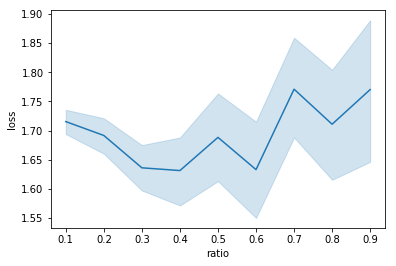

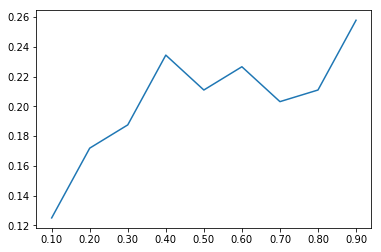

Data Preparation: 71.7s
Epoch: 6 (183.5s)  LR: 0.00078 Train Loss: 1.561384  Valid Loss: 1.625896  Valid Acc: (0.234375, 0.156250)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 6.8s
Epoch: 7 (172.5s)  LR: 0.00082 Train Loss: 1.467716  Valid Loss: 1.446553  Valid Acc: (0.265625, 0.312500)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 20.6s
Epoch: 8 (170.3s)  LR: 0.00085 Train Loss: 1.367765  Valid Loss: 1.340276  Valid Acc: (0.304688, 0.328125)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 20.4s
Epoch: 9 (175.2s)  LR: 0.00088 Train Loss: 1.224299  Valid Loss: 1.230512  Valid Acc: (0.406250, 0.414062)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 11.1s
Epoch: 10 (179.2s)  LR: 0.00091 Train Loss: 1.168874  Valid Loss: 1.319454  Valid Acc: (0.343750, 0.351562)


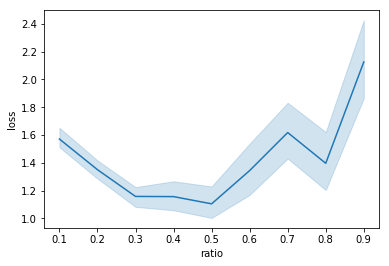

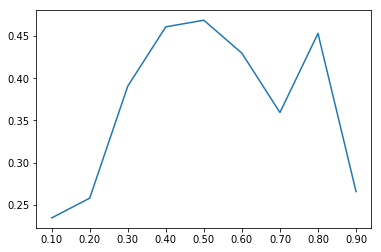

Data Preparation: 69.7s
Epoch: 11 (178.7s)  LR: 0.00094 Train Loss: 1.173213  Valid Loss: 1.344707  Valid Acc: (0.375000, 0.421875)
Data Preparation: 3.5s
Epoch: 12 (176.1s)  LR: 0.00096 Train Loss: 1.155769  Valid Loss: 1.470111  Valid Acc: (0.250000, 0.359375)
Data Preparation: 9.3s
Epoch: 13 (173.5s)  LR: 0.00098 Train Loss: 1.155694  Valid Loss: 1.437776  Valid Acc: (0.320312, 0.281250)
Data Preparation: 26.0s
Epoch: 14 (179.3s)  LR: 0.00099 Train Loss: 1.065427  Valid Loss: 1.472893  Valid Acc: (0.414062, 0.351562)
Data Preparation: 15.4s
Epoch: 15 (183.7s)  LR: 0.00100 Train Loss: 1.084225  Valid Loss: 1.542559  Valid Acc: (0.273438, 0.312500)


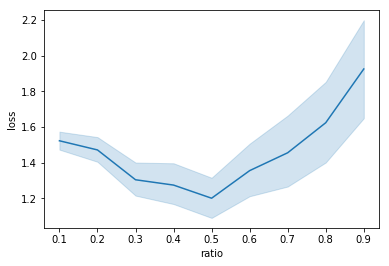

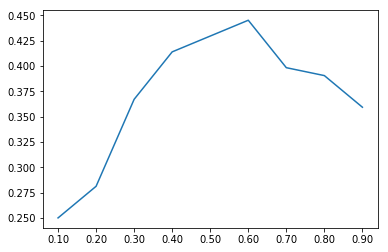

Data Preparation: 64.6s
Epoch: 16 (164.9s)  LR: 0.00100 Train Loss: 1.070140  Valid Loss: 1.573729  Valid Acc: (0.445312, 0.312500)
Data Preparation: 46.4s
Epoch: 17 (178.7s)  LR: 0.00100 Train Loss: 1.031194  Valid Loss: 1.485881  Valid Acc: (0.406250, 0.351562)
Data Preparation: 30.0s
Epoch: 18 (178.0s)  LR: 0.00099 Train Loss: 0.989821  Valid Loss: 1.256437  Valid Acc: (0.375000, 0.476562)
Data Preparation: 34.3s
Epoch: 19 (186.6s)  LR: 0.00098 Train Loss: 0.882759  Valid Loss: 1.528805  Valid Acc: (0.437500, 0.375000)
Data Preparation: 22.4s
Epoch: 20 (187.0s)  LR: 0.00096 Train Loss: 0.868570  Valid Loss: 1.492641  Valid Acc: (0.398438, 0.406250)


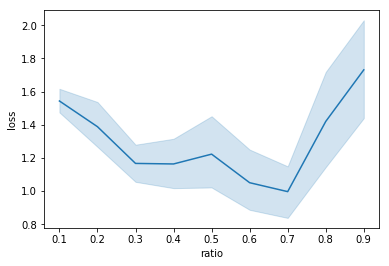

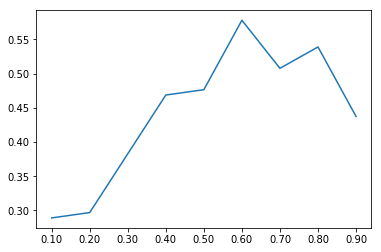

Data Preparation: 85.2s
Epoch: 21 (177.1s)  LR: 0.00094 Train Loss: 0.927936  Valid Loss: 2.046675  Valid Acc: (0.304688, 0.265625)
Data Preparation: 7.1s
Epoch: 22 (181.3s)  LR: 0.00092 Train Loss: 0.820895  Valid Loss: 1.915446  Valid Acc: (0.312500, 0.289062)
Data Preparation: 12.3s
Epoch: 23 (181.9s)  LR: 0.00089 Train Loss: 0.875886  Valid Loss: 1.779948  Valid Acc: (0.281250, 0.351562)
Data Preparation: 17.8s
Epoch: 24 (177.9s)  LR: 0.00086 Train Loss: 0.887017  Valid Loss: 1.544618  Valid Acc: (0.281250, 0.312500)
Data Preparation: 19.0s
Epoch: 25 (188.7s)  LR: 0.00082 Train Loss: 0.881956  Valid Loss: 1.493329  Valid Acc: (0.312500, 0.351562)


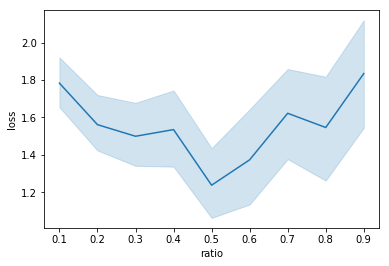

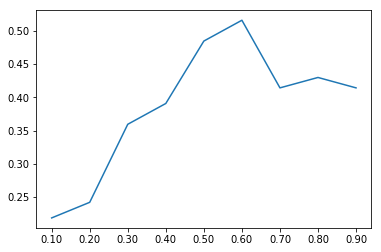

Data Preparation: 65.8s
Epoch: 26 (181.8s)  LR: 0.00079 Train Loss: 0.846261  Valid Loss: 1.463445  Valid Acc: (0.390625, 0.367188)
Data Preparation: 27.1s
Epoch: 27 (178.8s)  LR: 0.00075 Train Loss: 0.893463  Valid Loss: 2.000548  Valid Acc: (0.250000, 0.242188)
Data Preparation: 25.8s
Epoch: 28 (184.8s)  LR: 0.00070 Train Loss: 0.820400  Valid Loss: 1.335057  Valid Acc: (0.304688, 0.437500)
Data Preparation: 26.9s
Epoch: 29 (181.5s)  LR: 0.00066 Train Loss: 0.775591  Valid Loss: 1.274315  Valid Acc: (0.398438, 0.476562)
Data Preparation: 29.8s
Epoch: 30 (177.8s)  LR: 0.00061 Train Loss: 0.730622  Valid Loss: 1.715903  Valid Acc: (0.203125, 0.390625)


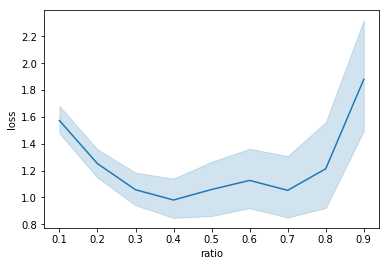

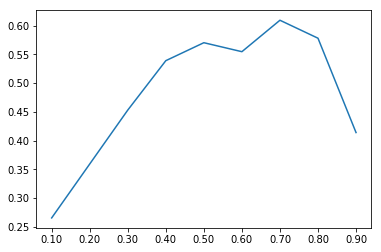

Data Preparation: 64.5s
Epoch: 31 (179.7s)  LR: 0.00056 Train Loss: 0.790630  Valid Loss: 1.295702  Valid Acc: (0.257812, 0.351562)
Data Preparation: 23.9s
Epoch: 32 (175.0s)  LR: 0.00051 Train Loss: 0.782995  Valid Loss: 1.187596  Valid Acc: (0.421875, 0.476562)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 33.6s
Epoch: 33 (182.3s)  LR: 0.00046 Train Loss: 0.749005  Valid Loss: 1.301393  Valid Acc: (0.304688, 0.429688)
Data Preparation: 34.6s
Epoch: 34 (181.4s)  LR: 0.00042 Train Loss: 0.836011  Valid Loss: 1.236166  Valid Acc: (0.515625, 0.468750)
Data Preparation: 28.5s
Epoch: 35 (189.0s)  LR: 0.00037 Train Loss: 0.841046  Valid Loss: 1.465848  Valid Acc: (0.304688, 0.375000)


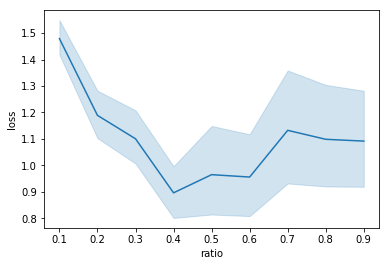

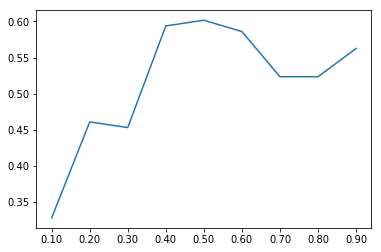

Data Preparation: 82.8s
Epoch: 36 (180.7s)  LR: 0.00032 Train Loss: 0.779498  Valid Loss: 1.387667  Valid Acc: (0.398438, 0.343750)
Data Preparation: 23.5s
Epoch: 37 (178.8s)  LR: 0.00028 Train Loss: 0.761827  Valid Loss: 1.510643  Valid Acc: (0.335938, 0.351562)
Data Preparation: 4.4s
Epoch: 38 (173.4s)  LR: 0.00024 Train Loss: 0.774416  Valid Loss: 1.300871  Valid Acc: (0.328125, 0.507812)
Data Preparation: 10.0s
Epoch: 39 (176.3s)  LR: 0.00020 Train Loss: 0.762108  Valid Loss: 1.256495  Valid Acc: (0.382812, 0.414062)
Data Preparation: 27.5s
Epoch: 40 (179.5s)  LR: 0.00016 Train Loss: 0.747297  Valid Loss: 1.287489  Valid Acc: (0.414062, 0.453125)


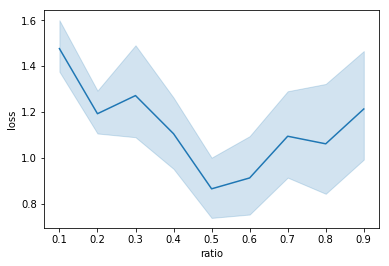

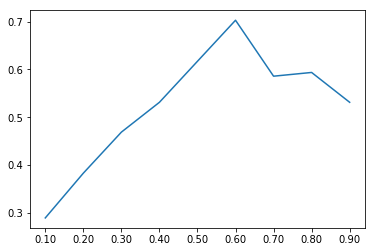

Data Preparation: 65.2s
Epoch: 41 (175.2s)  LR: 0.00012 Train Loss: 0.704851  Valid Loss: 1.238438  Valid Acc: (0.421875, 0.492188)
Data Preparation: 34.9s
Epoch: 42 (182.4s)  LR: 0.00009 Train Loss: 0.708834  Valid Loss: 1.303265  Valid Acc: (0.421875, 0.398438)
Data Preparation: 32.1s
Epoch: 43 (184.1s)  LR: 0.00007 Train Loss: 0.767922  Valid Loss: 1.314884  Valid Acc: (0.429688, 0.429688)
Data Preparation: 22.6s
Epoch: 44 (183.1s)  LR: 0.00005 Train Loss: 0.763953  Valid Loss: 1.280746  Valid Acc: (0.429688, 0.484375)
Data Preparation: 26.2s
Epoch: 45 (182.7s)  LR: 0.00003 Train Loss: 0.720256  Valid Loss: 1.289022  Valid Acc: (0.484375, 0.445312)


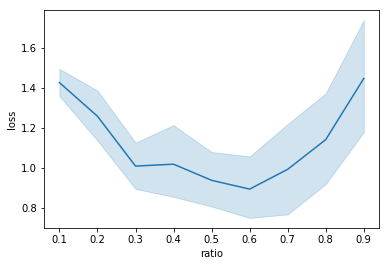

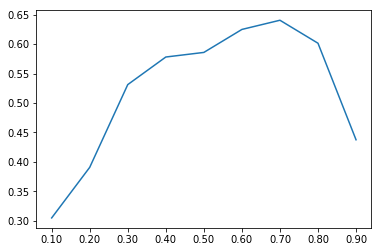

Data Preparation: 79.2s
Epoch: 46 (179.1s)  LR: 0.00001 Train Loss: 0.762697  Valid Loss: 1.295530  Valid Acc: (0.468750, 0.484375)
Data Preparation: 4.5s
Epoch: 47 (175.6s)  LR: 0.00001 Train Loss: 0.737106  Valid Loss: 1.273160  Valid Acc: (0.437500, 0.414062)
Data Preparation: 22.5s
Epoch: 48 (183.3s)  LR: 0.00000 Train Loss: 0.817410  Valid Loss: 1.190945  Valid Acc: (0.468750, 0.492188)
Data Preparation: 19.6s
Epoch: 49 (187.9s)  LR: 0.00000 Train Loss: 0.750061  Valid Loss: 1.268629  Valid Acc: (0.445312, 0.492188)
Data Preparation: 7.5s
Epoch: 50 (174.7s)  LR: 0.00001 Train Loss: 0.752820  Valid Loss: 1.198916  Valid Acc: (0.445312, 0.453125)


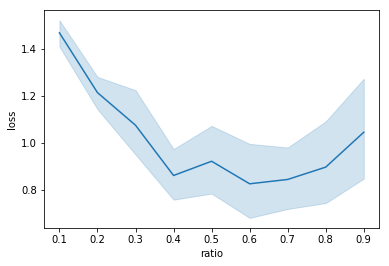

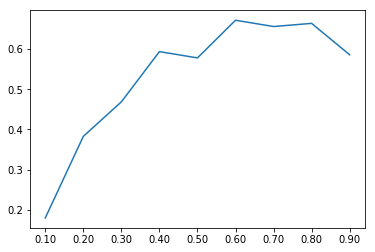

Data Preparation: 67.8s
Epoch: 51 (179.6s)  LR: 0.00002 Train Loss: 0.732265  Valid Loss: 1.302024  Valid Acc: (0.421875, 0.375000)
Data Preparation: 32.3s
Epoch: 52 (182.8s)  LR: 0.00003 Train Loss: 0.670876  Valid Loss: 1.331831  Valid Acc: (0.375000, 0.453125)
Data Preparation: 28.0s
Epoch: 53 (181.4s)  LR: 0.00005 Train Loss: 0.734089  Valid Loss: 1.292076  Valid Acc: (0.406250, 0.476562)
Data Preparation: 25.0s
Epoch: 54 (184.8s)  LR: 0.00007 Train Loss: 0.688736  Valid Loss: 1.215419  Valid Acc: (0.359375, 0.429688)
Data Preparation: 22.1s
Epoch: 55 (173.4s)  LR: 0.00010 Train Loss: 0.748126  Valid Loss: 1.183595  Valid Acc: (0.406250, 0.453125)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


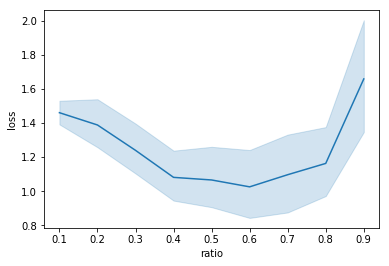

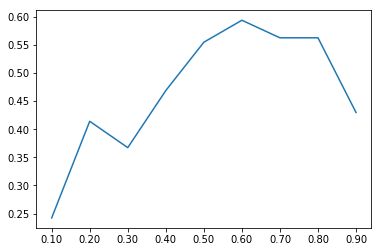

Data Preparation: 79.7s
Epoch: 56 (183.7s)  LR: 0.00013 Train Loss: 0.655901  Valid Loss: 1.244258  Valid Acc: (0.476562, 0.414062)
Data Preparation: 14.2s
Epoch: 57 (180.2s)  LR: 0.00017 Train Loss: 0.676141  Valid Loss: 1.169781  Valid Acc: (0.484375, 0.507812)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 12.0s
Epoch: 58 (191.4s)  LR: 0.00020 Train Loss: 0.742871  Valid Loss: 1.096556  Valid Acc: (0.460938, 0.578125)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 3.8s
Epoch: 59 (178.7s)  LR: 0.00024 Train Loss: 0.668049  Valid Loss: 1.362773  Valid Acc: (0.382812, 0.429688)
Data Preparation: 3.6s
Epoch: 60 (174.6s)  LR: 0.00029 Train Loss: 0.682679  Valid Loss: 1.222597  Valid Acc: (0.414062, 0.578125)


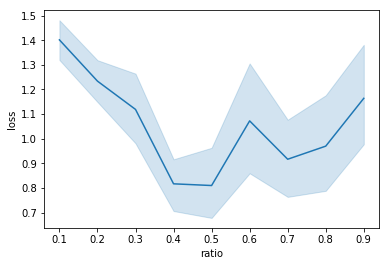

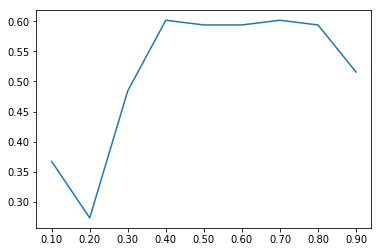

Data Preparation: 69.4s
Epoch: 61 (189.5s)  LR: 0.00033 Train Loss: 0.676675  Valid Loss: 1.148068  Valid Acc: (0.359375, 0.507812)
Data Preparation: 21.1s
Epoch: 62 (190.4s)  LR: 0.00038 Train Loss: 0.638643  Valid Loss: 1.223835  Valid Acc: (0.367188, 0.515625)
Data Preparation: 29.6s
Epoch: 63 (187.6s)  LR: 0.00043 Train Loss: 0.732915  Valid Loss: 1.206382  Valid Acc: (0.468750, 0.453125)
Data Preparation: 37.8s
Epoch: 64 (179.4s)  LR: 0.00048 Train Loss: 0.683582  Valid Loss: 1.219596  Valid Acc: (0.507812, 0.523438)
Data Preparation: 30.2s
Epoch: 65 (175.2s)  LR: 0.00052 Train Loss: 0.732039  Valid Loss: 1.264196  Valid Acc: (0.460938, 0.414062)


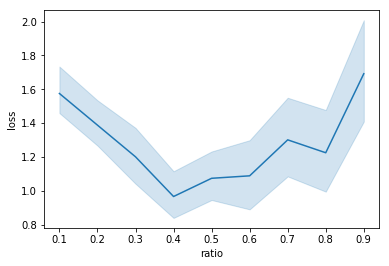

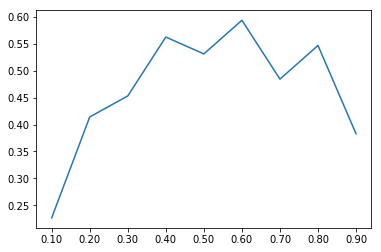

Data Preparation: 68.1s
Epoch: 66 (183.8s)  LR: 0.00057 Train Loss: 0.737684  Valid Loss: 1.063429  Valid Acc: (0.429688, 0.562500)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Data Preparation: 26.1s
Epoch: 67 (145.7s)  LR: 0.00062 Train Loss: 0.709275  Valid Loss: 1.222766  Valid Acc: (0.468750, 0.531250)
Data Preparation: 45.3s
Epoch: 68 (134.1s)  LR: 0.00067 Train Loss: 0.661235  Valid Loss: 1.138831  Valid Acc: (0.468750, 0.539062)
Data Preparation: 49.8s
Epoch: 69 (145.2s)  LR: 0.00071 Train Loss: 0.725636  Valid Loss: 1.214604  Valid Acc: (0.421875, 0.468750)
Data Preparation: 38.1s
Epoch: 70 (140.1s)  LR: 0.00075 Train Loss: 0.737584  Valid Loss: 1.267218  Valid Acc: (0.492188, 0.445312)


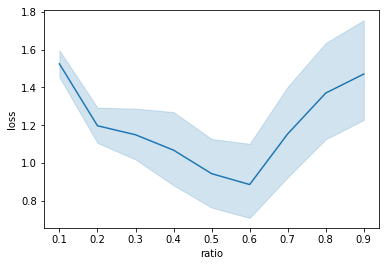

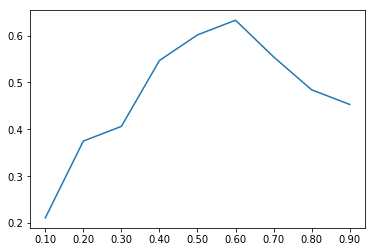

Data Preparation: 75.4s
Epoch: 71 (142.0s)  LR: 0.00080 Train Loss: 0.743540  Valid Loss: 1.142300  Valid Acc: (0.500000, 0.515625)
Data Preparation: 33.8s
Epoch: 72 (144.6s)  LR: 0.00083 Train Loss: 0.707346  Valid Loss: 1.211877  Valid Acc: (0.445312, 0.468750)
Data Preparation: 34.8s
Epoch: 73 (143.7s)  LR: 0.00087 Train Loss: 0.762361  Valid Loss: 1.274491  Valid Acc: (0.406250, 0.523438)
Data Preparation: 24.8s
Epoch: 74 (134.8s)  LR: 0.00090 Train Loss: 0.781167  Valid Loss: 1.416910  Valid Acc: (0.398438, 0.375000)
Data Preparation: 45.3s
Epoch: 75 (145.1s)  LR: 0.00093 Train Loss: 0.742161  Valid Loss: 1.470319  Valid Acc: (0.453125, 0.359375)


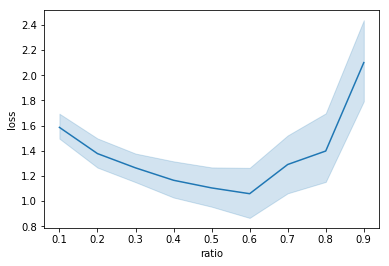

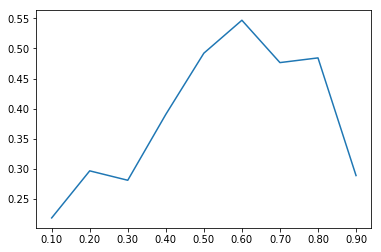

Data Preparation: 62.8s
Epoch: 76 (135.7s)  LR: 0.00095 Train Loss: 0.792703  Valid Loss: 1.146715  Valid Acc: (0.453125, 0.593750)
Data Preparation: 59.2s
Epoch: 77 (143.3s)  LR: 0.00097 Train Loss: 0.754427  Valid Loss: 1.268502  Valid Acc: (0.382812, 0.414062)
Data Preparation: 46.9s
Epoch: 78 (141.9s)  LR: 0.00098 Train Loss: 0.766230  Valid Loss: 1.162375  Valid Acc: (0.429688, 0.500000)
Data Preparation: 42.0s
Epoch: 79 (135.7s)  LR: 0.00099 Train Loss: 0.717054  Valid Loss: 1.393548  Valid Acc: (0.406250, 0.414062)
Data Preparation: 48.0s
Epoch: 80 (137.2s)  LR: 0.00100 Train Loss: 0.770120  Valid Loss: 1.342429  Valid Acc: (0.406250, 0.398438)


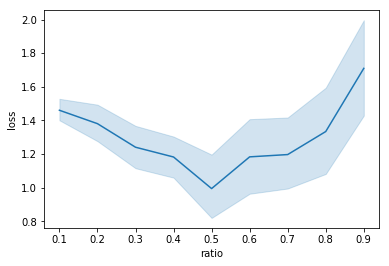

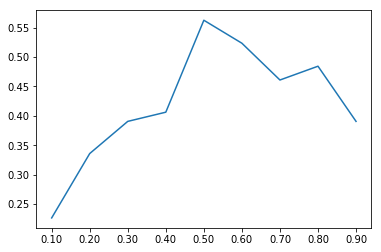

Data Preparation: 76.8s
Epoch: 81 (139.2s)  LR: 0.00100 Train Loss: 0.734391  Valid Loss: 1.547713  Valid Acc: (0.343750, 0.359375)
Data Preparation: 37.2s
Epoch: 82 (142.0s)  LR: 0.00100 Train Loss: 0.763986  Valid Loss: 1.424965  Valid Acc: (0.359375, 0.406250)
Data Preparation: 29.8s
Epoch: 83 (145.2s)  LR: 0.00099 Train Loss: 0.808483  Valid Loss: 1.555050  Valid Acc: (0.398438, 0.359375)
Data Preparation: 29.8s
Epoch: 84 (147.6s)  LR: 0.00097 Train Loss: 0.851528  Valid Loss: 1.678143  Valid Acc: (0.281250, 0.289062)
Data Preparation: 29.3s
Epoch: 85 (137.7s)  LR: 0.00096 Train Loss: 0.866522  Valid Loss: 1.654835  Valid Acc: (0.382812, 0.367188)


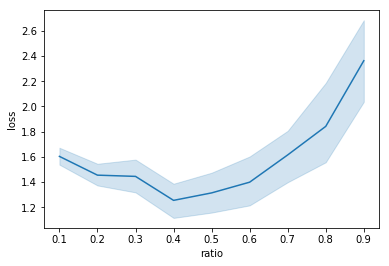

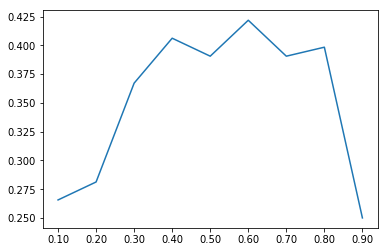

Data Preparation: 64.1s
Epoch: 86 (144.0s)  LR: 0.00093 Train Loss: 0.898783  Valid Loss: 1.244610  Valid Acc: (0.429688, 0.437500)
Data Preparation: 41.9s
Epoch: 87 (135.2s)  LR: 0.00091 Train Loss: 0.813740  Valid Loss: 1.704970  Valid Acc: (0.320312, 0.265625)
Data Preparation: 59.3s
Epoch: 88 (139.8s)  LR: 0.00088 Train Loss: 0.770555  Valid Loss: 1.511183  Valid Acc: (0.421875, 0.312500)
Data Preparation: 45.0s
Epoch: 89 (141.6s)  LR: 0.00084 Train Loss: 0.762763  Valid Loss: 1.481889  Valid Acc: (0.359375, 0.507812)
Data Preparation: 50.6s
Epoch: 90 (149.0s)  LR: 0.00081 Train Loss: 0.727214  Valid Loss: 1.844883  Valid Acc: (0.328125, 0.273438)


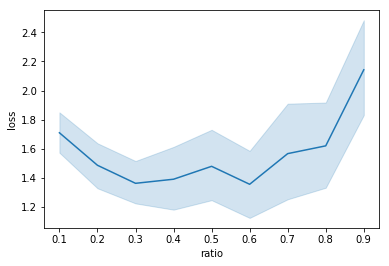

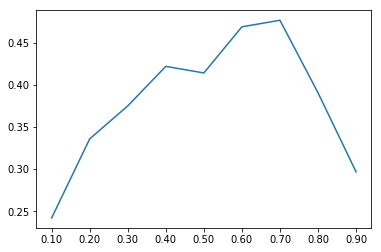

Data Preparation: 74.9s
Epoch: 91 (151.8s)  LR: 0.00077 Train Loss: 0.801616  Valid Loss: 2.282496  Valid Acc: (0.335938, 0.335938)
Data Preparation: 31.1s
Epoch: 92 (145.9s)  LR: 0.00072 Train Loss: 0.755852  Valid Loss: 1.622601  Valid Acc: (0.390625, 0.281250)
Data Preparation: 36.9s
Epoch: 93 (145.9s)  LR: 0.00068 Train Loss: 0.736189  Valid Loss: 1.483202  Valid Acc: (0.304688, 0.343750)
Data Preparation: 31.0s
Epoch: 94 (145.9s)  LR: 0.00063 Train Loss: 0.646006  Valid Loss: 1.722673  Valid Acc: (0.351562, 0.351562)
Data Preparation: 35.4s
Epoch: 95 (151.4s)  LR: 0.00059 Train Loss: 0.676240  Valid Loss: 1.786445  Valid Acc: (0.265625, 0.257812)


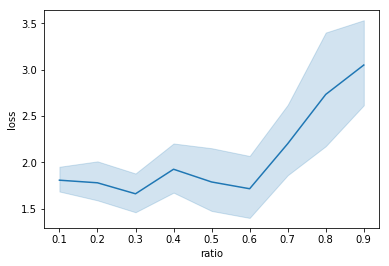

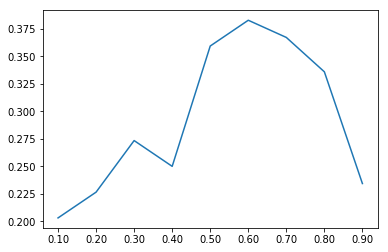

Data Preparation: 65.5s
Epoch: 96 (150.8s)  LR: 0.00054 Train Loss: 0.642396  Valid Loss: 2.445230  Valid Acc: (0.289062, 0.242188)
Data Preparation: 45.3s
Epoch: 97 (144.5s)  LR: 0.00049 Train Loss: 0.644638  Valid Loss: 2.407432  Valid Acc: (0.265625, 0.312500)
Data Preparation: 40.6s
Epoch: 98 (143.0s)  LR: 0.00044 Train Loss: 0.631842  Valid Loss: 2.506668  Valid Acc: (0.320312, 0.304688)


MaybeEncodingError: Error sending result: '((tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.2229,  0.0960,  1.8809],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1856, -0.0494,  1.3804],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.3714, -0.2522,  0.6031],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0542,  0.3356,  2.5238],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0542,  0.3356,  2.5238],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0542,  0.3356,  2.5238]]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([120, 120, 120,  ..., 125, 125, 125]), tensor([[   0,    1,    2,  ..., 1265, 1265, 1265],
        [   0,    1,    2,  ..., 2124, 2125, 2126]]), tensor([38, 38, 38,  ..., 19, 19, 19]), {'paper': [0, 0], 'venue': [400, 1], 'field': [687, 2], 'author': [987, 3], 'affiliation': [1287, 4], 'fake_paper': [1487, 0]}, {'PV_Conference': 0, 'PV_Journal': 1, 'PV_Repository': 2, 'PV_Patent': 3, 'APV_in': 4, 'rev_PV_Conference': 5, 'rev_PV_Journal': 6, 'rev_PV_Repository': 7, 'rev_PV_Patent': 20, 'PP_cite': 9, 'rev_PP_cite': 10, 'rev_PF_in_L0': 11, 'rev_PF_in_L3': 12, 'rev_PF_in_L1': 13, 'rev_PF_in_L2': 14, 'rev_PF_in_L5': 15, 'rev_PF_in_L4': 16, 'AP_write_last': 17, 'AP_write_other': 18, 'AP_write_first': 19, 'FF_in': 21, 'rev_FF_in': 22, 'PF_in_L0': 23, 'PF_in_L3': 24, 'PF_in_L1': 25, 'PF_in_L2': 26, 'PF_in_L5': 27, 'PF_in_L4': 28, 'APF_in': 29, 'in': 30, 'IPI_coauthor': 31, 'rev_in': 32, 'rev_APV_in': 33, 'rev_APF_in': 34, 'rev_AP_write_last': 35, 'rev_AP_write_other': 36, 'rev_AP_write_first': 37, 'APA_coauthor': 38, 'self': 38}), array([ 40, 296, 105, 128, 282, 273, 240, 375, 315,   5, 295, 188,  11,
       191,  60, 382, 162, 363, 165, 144, 215, 232, 262, 170, 190, 349,
         6, 307, 376,  39, 163, 284, 364, 344, 120, 166, 261,  82, 143,
       213,  74, 117, 172, 305, 197, 126, 112, 148, 370,  48, 277,  85,
       139, 225, 319, 255, 219,  94, 339, 237, 204, 216, 335, 369,  19,
        38,   0, 372,  80, 357,   9, 292, 115, 196, 140, 289, 334, 371,
        21, 293, 192,  84, 212, 210, 351,  73, 160, 256, 217, 176, 108,
       378, 328,  55, 250,  69,  50, 119, 343,  41, 332, 331, 180, 346,
       336, 312, 342, 147,   7, 269, 265, 235,  90, 194, 183,  86,  91,
       258, 266,  23, 299, 287, 286, 241, 198,  87, 381, 130]), 640)'. Reason: 'RuntimeError('unable to write to file </torch_77338_1959842209>')'

In [8]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 100000
for epoch in np.arange(epoch_num)+1:
    train_data = [job.get() for job in jobs[:-2]]
    valid_data = [jobs[-2].get(), jobs[-1].get()]
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    train_losses = []
    cpc_predictor.train()
    torch.cuda.empty_cache()
    for data, paper_ids, num_fake in train_data:
        loss, pred = cpc_loss(data, paper_ids, num_fake, cpc_predictor, device)
        optimizer.zero_grad() 
        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(cpc_predictor.parameters(), 0.2)
        optimizer.step()
        train_losses += loss.cpu().detach().tolist()
        train_step += 1
        scheduler.step(train_step)
        del loss, pred
        torch.cuda.empty_cache()
    '''
        Valid
    '''
    cpc_predictor.eval()
    with torch.no_grad():
        valid_accs   = []
        valid_losses = []
        for data, paper_ids, num_fake in valid_data:
            loss, pred = cpc_loss(data, paper_ids, num_fake, cpc_predictor, device)
            valid_losses += loss.cpu().detach().tolist()
            s = (pred.argmax(dim=1) == 0).sum()
            valid_accs += [s.tolist()/batch_size]
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %f  Valid Loss: %f  Valid Acc: (%f, %f)") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), \
               np.average(valid_losses), valid_accs[0], valid_accs[1]))
        if np.average(valid_losses) < best_val:
            best_val = np.average(valid_losses)
            torch.save(cpc_predictor.gnn, './save/cpc_model.pt')
        stats += [[train_losses, valid_losses]]
        
        if epoch % 5 == 0:
            feature, _time, edge_list, _ = sample_subgraph(graph, test_range, inp = None, sampled_depth = 4, sampled_number = 128)
            losses = []
            accs   = []
            for ratio in np.arange(9) / 10 + 0.1:
                fake_feature, fake_time, fake_edge_list, paper_ids = cpc_sample(np.random.randint(2**32 - 1), \
                                                                feature, _time, edge_list, batch_size, 5, ratio)
                data = to_torch(fake_feature, fake_time, fake_edge_list, graph)
                loss, pred = cpc_loss(data, paper_ids, len(fake_time['fake_paper']), cpc_predictor, device)
                for li in loss.tolist():
                    losses += [[li, ratio]]
                s = (pred.argmax(dim=1) == 0).sum()
                acc = s.tolist() / batch_size
                accs += [acc]
                del loss, pred
                torch.cuda.empty_cache()
            sb.lineplot(data = pd.DataFrame(losses, columns=['loss', 'ratio']), x = 'ratio', y='loss')
            plt.show()
            plt.plot(accs)
            plt.xticks(np.arange(9), ['%.2f' % si for si in np.arange(9) / 10 + 0.1])
            plt.show()

In [ ]:
losses = []
for epoch, (train_losses, valid_losses) in enumerate(stats):
    for ti in train_losses:
        losses += [[ti, 'Train', epoch]]
#     for ti in valid_losses:
#         losses += [[ti, 'Valid', epoch]]

In [ ]:
sb.lineplot(data = pd.DataFrame(losses, columns=['loss', 'Type', 'Epoch']), x = 'Epoch', y='loss', hue='Type')
plt.show()